In [1]:
import sys, os, decimal, json
sys.path.append(os.path.realpath('..'))
import json, time
import pandas as pd
import random
import matplotlib.pyplot as plt
import glob

import matplotlib.pyplot as plt
import numpy as np
import PIL, json
import tensorflow as tf
import socket
import pathlib
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageOps

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

from TrainingPipelines.ImageClassifier.ModelBuilder import build_and_train

import seaborn as sns
import mplcyberpunk

plt.style.use("cyberpunk")
plt.rcParams['figure.facecolor'] = '#0d1117'
plt.rcParams['axes.facecolor'] = '#0d1117'
plt.rcParams['savefig.facecolor'] = '#0d1117'

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
reduction = 1

img_width = int(500/reduction)
img_height = int(600/reduction)

In [4]:
image_names = []
path = pathlib.Path(r'O:\eve_models\training_data\route_y')
for data in glob.glob(f"{path}\*.png"):
    file = data.split('\\')[-1:][0]
    image_names.append(file)

In [5]:
random.shuffle(image_names)

In [6]:
image_data = {}
f = open(f"{path}\\boxes.json")
image_data_raw = json.load(f)
f.close()

for data in image_data_raw:
    image_data[data['image_name']] = data['bbox'][1:2]
image_data[list(image_data.keys())[0]]

[377]

In [7]:
train_names, val_names, test_names = np.split(image_names, [int(len(image_names)*0.8), int(len(image_names)*0.9)])

In [8]:
train_x = []
for image_name in tqdm(train_names):
    try:
        img = Image.open(f"{path}\\{image_name}")
        if reduction != 1:
            img = img.resize((img_width, img_height), resample=Image.Resampling.LANCZOS)
        train_x.append(np.array(img))
    except:
        print(f"{path}\\{image_name}")
    
val_x = []
for image_name in tqdm(val_names):
    img = Image.open(f"{path}\\{image_name}")
    if reduction != 1:
        img = img.resize((img_width, img_height), resample=Image.Resampling.LANCZOS)
    val_x.append(np.array(img))
    
test_x = []
for image_name in tqdm(test_names):
    img = Image.open(f"{path}\\{image_name}")
    if reduction != 1:
        img = img.resize((img_width, img_height), resample=Image.Resampling.LANCZOS)
    test_x.append(np.array(img))
    
train_x = np.array(train_x)
val_x = np.array(val_x)
test_x = np.array(test_x)

100%|█████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 239.99it/s]


In [9]:
train_x[0].shape

(600, 500, 3)

In [10]:
train_y = []
for image_name in tqdm(train_names):
    train_y.append(image_data[image_name])
    
val_y = []
for image_name in tqdm(val_names):
    val_y.append(image_data[image_name])
    
test_y = []
for image_name in tqdm(test_names):
    test_y.append(image_data[image_name])

train_y = np.array(train_y) / np.array([600])
val_y = np.array(val_y) / np.array([600])
test_y = np.array(test_y) / np.array([600])

100%|███████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 36028.38it/s]


In [11]:
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.callbacks import Callback


class LRFinder(Callback):
    """Callback that exponentially adjusts the learning rate after each training batch between start_lr and
    end_lr for a maximum number of batches: max_step. The loss and learning rate are recorded at each step allowing
    visually finding a good learning rate as per https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html via
    the plot method.
    """

    def __init__(self, start_lr: float = 1e-7, end_lr: float = 10, max_steps: int = 100, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1, 1)
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses)

In [12]:
model = Sequential([
    layers.Rescaling(1. / 255, input_shape=(img_height, img_width, 3)),
    #layers.Resizing(img_height, img_width, interpolation='bilinear', crop_to_aspect_ratio=False),
    #layers.Normalization(input_shape=(img_height, img_width, 3)),
    #vgg,
    #layers.GlobalAveragePooling2D(),
    #layers.Conv2D(4, 3, activation='relu'),
    #layers.MaxPooling2D(),
    #layers.Conv2D(8, 3, activation='relu'),
    #layers.MaxPooling2D(),
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    #layers.SpatialDropout2D(0.2),
    #layers.GlobalAvgPool2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    #layers.Conv2D(128, 3, activation='relu'),
    #layers.MaxPooling2D(),
    #layers.Conv2D(256, 3, activation='relu'),
    #layers.MaxPooling2D(),
    #layers.Conv2D(512, 3, activation='relu'),
    #layers.MaxPooling2D(),
    layers.Flatten(),
    #layers.Dropout(0.5),
    #layers.Dense(600, activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")    
])

In [13]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 600, 500, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 598, 498, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 299, 249, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 297, 247, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 148, 123, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 146, 121, 64)      1

In [ ]:
epochs =50
#lr = 1e-4
#lr=0.0020892961308540407
lr_finder = LRFinder()

callbacks = [
    #ReduceLROnPlateau(monitor='val_accuracy', factor=0.01, patience=5, min_lr=1e-10, verbose=1),
    lr_finder,
    #EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=False),
]

model.compile(optimizer=Adam(lr), loss='mse', metrics=['accuracy', 'mse'])

history = model.fit(
    x=train_x,
    y=train_y,
    validation_data=(val_x, val_y),
    batch_size=32,
    #shuffle=True,
    epochs=epochs,
    callbacks=callbacks
)

lr = lr_finder.__dict__['lrs'][np.argmin(lr_finder.__dict__['losses'])]

print(f"Optimal lr:{lr}")

model.compile(optimizer=Adam(lr), loss='mse', metrics=['accuracy', 'mse'])

history = model.fit(
    x=train_x,
    y=train_y,
    validation_data=(val_x, val_y),
    batch_size=32,
    #shuffle=True,
    epochs=epochs,
    callbacks=None
)

Epoch 1/50
9/9 [==============================] - 9s 978ms/step - loss: 8.6838e-06 - accuracy: 0.0000e+00 - mse: 8.6838e-06 - val_loss: 1.7375e-04 - val_accuracy: 0.0000e+00 - val_mse: 1.7375e-04
Epoch 2/50
9/9 [==============================] - 9s 962ms/step - loss: 7.8858e-06 - accuracy: 0.0000e+00 - mse: 7.8858e-06 - val_loss: 1.6740e-04 - val_accuracy: 0.0000e+00 - val_mse: 1.6740e-04
Epoch 3/50
9/9 [==============================] - 9s 971ms/step - loss: 6.0167e-06 - accuracy: 0.0000e+00 - mse: 6.0167e-06 - val_loss: 1.4877e-04 - val_accuracy: 0.0000e+00 - val_mse: 1.4877e-04
Epoch 4/50
9/9 [==============================] - 9s 968ms/step - loss: 5.1716e-06 - accuracy: 0.0000e+00 - mse: 5.1716e-06 - val_loss: 1.4787e-04 - val_accuracy: 0.0000e+00 - val_mse: 1.4787e-04
Epoch 5/50
9/9 [==============================] - 9s 967ms/step - loss: 4.7173e-06 - accuracy: 0.0000e+00 - mse: 4.7173e-06 - val_loss: 1.1862e-04 - val_accuracy: 0.0000e+00 - val_mse: 1.1862e-04
Epoch 6/50
9/9 [====

In [15]:
lr_finder.__dict__['lrs'][np.argmin(lr_finder.__dict__['losses'])]

0.0020892961308540407

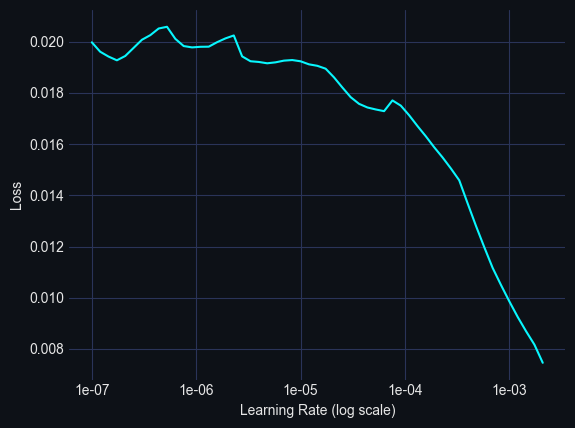

In [16]:
lr_finder.plot()

1/1 [==============================] - 0s 16ms/step
[257.6000154]
[255.]


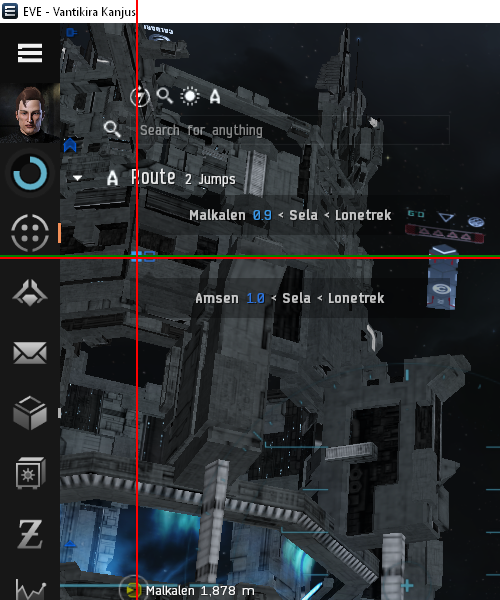

In [31]:
test_image_index = 10

prediction = model.predict(np.array([test_x[test_image_index]]))
result = ((prediction) * np.array([600])) # reduction
result = result[0]
print(result)
truth = (test_y[test_image_index] * np.array([600])) # reduction
print(truth)

#mg = Image.fromarray(test_x[test_image_index]) 
img = Image.open(f"{path}\\{test_names[test_image_index]}")
img1 = ImageDraw.Draw(img)  
#img1.ellipse((result[0]-10,result[1]-10,result[0]+10,result[1]+10), outline ="red", width=5)
#img1.ellipse((truth[0]-10,truth[1]-10,truth[0]+10,truth[1]+10), outline ="Green", width=5)
img1.line([(0,truth[0]),(500,truth[0])], fill ="Green", width=2)
img1.line([(0,result[0]),(500,result[0])], fill ="Red", width=2)
img1.line([(136,0),(136,600)], fill ="Red", width=2)


img